In [1]:
import numpy as np
from sklearn import ensemble
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import pickle


In [2]:
# #############################################################################
# Load data
data = pd.read_csv('../../SynData/data/GeneratedData.csv')
data = data.drop(['id'], axis=1)

In [3]:
# #############################################################################
# Training and Testing Data
X = data[['throughput']]
y = data['CPU']
X = X.fillna(X.mean())
scaler = MinMaxScaler(feature_range=(0, 100))
X = scaler.fit_transform(X)
#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=101)

n = len(X)
kf = KFold(n_splits=5)
fold = 0
for train_index, test_index in kf.split(X):
    fold += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [4]:
# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [5]:
prediction = clf.predict(X_test)
y_test = np.array(list(y_test))
prediction= np.array(prediction)
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': prediction.flatten()})
df

,Actual,Predicted
0,0.583270,0.582400
1,0.650780,0.650111
2,0.527807,0.528241
3,0.354581,0.355621
4,0.329383,0.330512
5,0.448639,0.448883
6,0.747385,0.745662
7,0.918318,0.915593
8,0.950428,0.946937
9,0.014316,0.017819


Text(0, 0.5, 'Deviance')

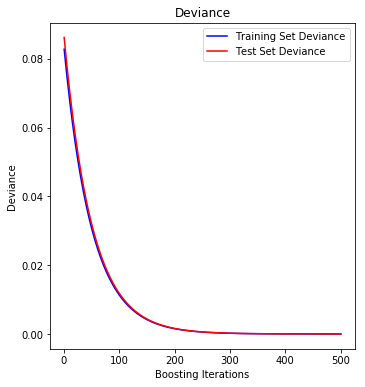

In [6]:
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')


In [7]:
#Model Evaluation
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))



MAE: 0.0017516531207870207
MSE: 4.181977803345806e-06
RMSE: 0.0020449884604431894


In [8]:
# save the model to disk
filename = '../models/gradientBoostingReg_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [9]:
clf.predict([[0]])

array([0.00675025])